In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from time import time   

pd.set_option('display.max_rows', 100)


In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
df_wpm15= pd.read_csv('data\pct15.csv')
df_wpm60= pd.read_csv('data\pct60.csv')

In [4]:
common = set(pd.read_csv('data\pct15.csv').name).intersection(set(pd.read_csv('data\pct60.csv').name))
df_both = pd.merge(df_wpm15[['name','wpm']].query("name in @common").rename(columns={"name":"name","wpm":"wpm15"}),df_wpm60[['name','wpm']].query("name in @common").rename(columns={"name":"name","wpm":"wpm60"}),how="left",on="name")
only60 = set(pd.read_csv('data\pct15.csv').name) - set(pd.read_csv('data\pct60.csv').name)
only15 = set(pd.read_csv('data\pct60.csv').name) - set(pd.read_csv('data\pct15.csv').name)
"""
df_trash = df_both[df_both.wpm15<df_both.wpm60].reset_index(drop=True)

df_both=df_both.query("name not in @df_trash.name")
df_wpm15=df_wpm15.query("name not in @df_trash.name")
df_wpm60=df_wpm60.query("name not in @df_trash.name")
"""

'\ndf_trash = df_both[df_both.wpm15<df_both.wpm60].reset_index(drop=True)\n\ndf_both=df_both.query("name not in @df_trash.name")\ndf_wpm15=df_wpm15.query("name not in @df_trash.name")\ndf_wpm60=df_wpm60.query("name not in @df_trash.name")\n'

In [5]:
s15 = df_wpm15.copy()[['wpm']].sort_values('wpm')
s60 = df_wpm60.copy()[['wpm']].sort_values('wpm')

In [6]:
df_conv=pd.read_csv('data\wpmtab.csv')

<function matplotlib.pyplot.show(close=None, block=None)>

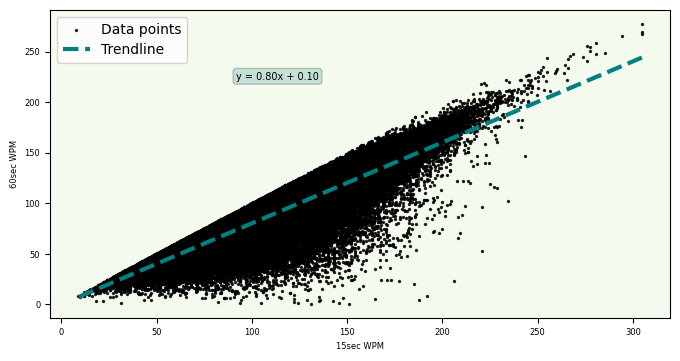

In [7]:

x = df_both['wpm15']
y = df_both['wpm60']

# Create the scatterplot
plt.figure(figsize=(8, 4))
plt.scatter(x, y, color = 'black',alpha=0.8,s=2, label='Data points')
coefficientsL = np.polyfit(x, y, 1)  # Linear fit (degree=1)
trendline = np.poly1d(coefficientsL)
plt.plot(x, trendline(x), color='teal',linestyle = '--',linewidth=3, label='Trendline')
equation = f"y = {coefficientsL[0]:.2f}x + {coefficientsL[1]:.2f}"
plt.text(0.3, 0.8, equation, transform=plt.gca().transAxes, fontsize=7, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="teal", alpha=0.2))
plt.gca().set_facecolor((.8, .9, .65, .20))
plt.ylabel("60sec WPM",fontsize=6)
plt.xlabel("15sec WPM",fontsize=6)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

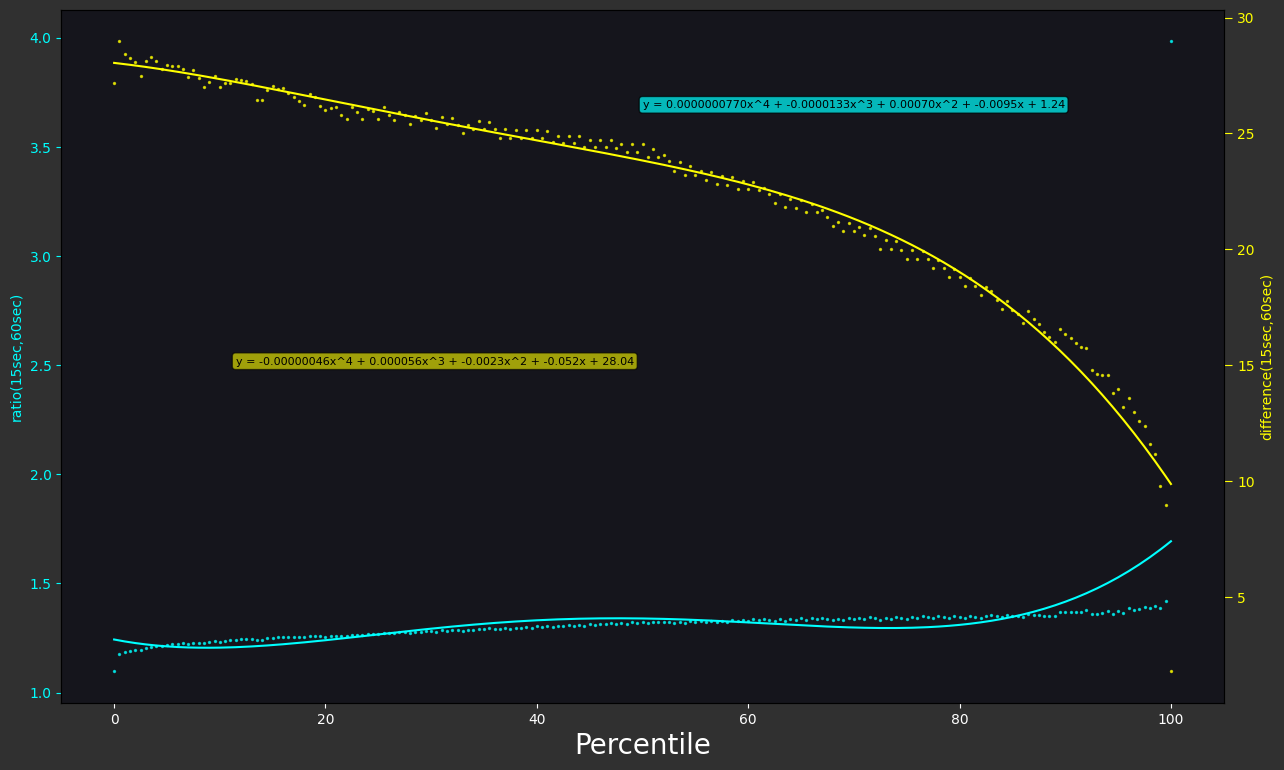

In [8]:
x = df_conv['pctl']
y = df_conv['mult']
z = df_conv['gap']

fig, ax1 = plt.subplots(figsize=(15, 9))

# Plot on the left y-axis
ax1.scatter(x, y, color = 'cyan',s=2, alpha =.7)
plt.xlabel("Percentile",fontsize=20,color='white')
ax1.set_ylabel('ratio(15sec,60sec)', color='cyan')
ax1.tick_params(axis='y', labelcolor='cyan',color='cyan')
ax1.tick_params(axis='x',labelcolor='white',color='white')
# Create the scatterplot

coefficients = np.polyfit(x, y, 4)  # Linear fit (degree=1)
trendline = np.poly1d (coefficients)
ax1.plot(x, trendline(x), color='cyan', label='Trendline')
equation = f"y = {coefficients[0]:.10f}x^4 + {coefficients[1]:.7f}x^3 + {coefficients[2]:.5f}x^2 + {coefficients[3]:.4f}x + {coefficients[4]:.2f}"
ax1.text(0.5, .87, equation, transform=plt.gca().transAxes, fontsize=8, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="cyan", alpha=0.7))
plt.gca().set_facecolor((0, 0, .05, .55))

ax2 = ax1.twinx()
ax2.scatter(x, z, color='yellow', s=2,alpha=0.7)
coefficients2 = np.polyfit(x, z, 4)  # Linear fit (degree=1)
trendline2 = np.poly1d (coefficients2)
ax2.plot(x, trendline2(x), color='yellow', label='Trendline')
equation2 = f"y = {coefficients2[0]:.8f}x^4 + {coefficients2[1]:.6f}x^3 + {coefficients2[2]:.4f}x^2 + {coefficients2[3]:.3f}x + {coefficients2[4]:.2f}"
ax2.text(0.15, .5, equation2, transform=plt.gca().transAxes, fontsize=8, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="yellow", alpha=0.6))
ax2.set_ylabel('difference(15sec,60sec)', color='yellow')
ax2.tick_params(axis='y',labelcolor='yellow',size=6,color='yellow')
fig.patch.set_facecolor((.1, .1, .1, 0.9))



plt.show

Algorithms: 
-  A ) uses the corresponding percentiles based on the average wpm of the equivalent percentile by groups of size .5
-  B ) uses the corresponding percentiles based on the CDF that includes all users
-  C ) uses the line of best fit with respect to only those users that have taken both tests
-  D ) uses the 4th degree polynomial line of best fit based on the ratio conversions at each percentile
-  E ) uses the 4th degree polynomial line of best fit based on the difference conversions at each percentile


In [9]:
# Pre-sort df_conv for fast lookup
df_conv_60_sorted = df_conv.sort_values("wpm60").reset_index(drop=True)
df_conv_15_sorted = df_conv.sort_values("wpm15").reset_index(drop=True)

def convertA(dir="up"):
    if dir == "up":
        w = df_both["wpm60"].values
        idxs = np.searchsorted(df_conv_60_sorted["wpm60"].values, w, side="right") - 1
        idxs = np.clip(idxs, 0, len(df_conv_60_sorted) - 1)
        multipliers = df_conv_60_sorted["mult"].iloc[idxs].values
        return multipliers * w
    else:
        w = df_both["wpm15"].values
        idxs = np.searchsorted(df_conv_15_sorted["wpm15"].values, w, side="right") - 1
        idxs = np.clip(idxs, 0, len(df_conv_15_sorted) - 1)
        multipliers = df_conv_15_sorted["mult"].iloc[idxs].values
        return w / multipliers

# Precompute and cache sorted numpy arrays and interpolation functions
def prepare_conversion_data():
    wpm60_sorted = df_wpm60.sort_values("wpm")
    wpm15_sorted = df_wpm15.sort_values("wpm")
    pct60_sorted = df_wpm60.sort_values("wpmpct")
    pct15_sorted = df_wpm15.sort_values("wpmpct")

    # Numpy arrays
    wpm60 = wpm60_sorted["wpm"].to_numpy()
    wpmpct60 = wpm60_sorted["wpmpct"].to_numpy()
    wpm15 = wpm15_sorted["wpm"].to_numpy()
    wpmpct15 = wpm15_sorted["wpmpct"].to_numpy()
    wpmpct15_sorted = pct15_sorted["wpmpct"].to_numpy()
    wpm15_sorted_by_pct = pct15_sorted["wpm"].to_numpy()
    wpmpct60_sorted = pct60_sorted["wpmpct"].to_numpy()
    wpm60_sorted_by_pct = pct60_sorted["wpm"].to_numpy()

    # Interpolation functions (extrapolate to avoid NaNs)
    interp_60_to_pct = interp1d(wpm60, wpmpct60, bounds_error=False, fill_value="extrapolate")
    interp_15_to_pct = interp1d(wpm15, wpmpct15, bounds_error=False, fill_value="extrapolate")

    return {
        "interp_60_to_pct": interp_60_to_pct,
        "interp_15_to_pct": interp_15_to_pct,
        "wpmpct15_sorted": wpmpct15_sorted,
        "wpm15_sorted": wpm15_sorted_by_pct,
        "wpmpct60_sorted": wpmpct60_sorted,
        "wpm60_sorted": wpm60_sorted_by_pct,
    }

# Cache this at module level or as a singleton
conversion_data = prepare_conversion_data()

# Main conversion function
def convertB(dir="up"):
    if dir == "up":
        # Convert wpm60 -> wpmpct -> wpm15
        pct_values = conversion_data["interp_60_to_pct"](df_both["wpm60"].to_numpy())
        idx = np.searchsorted(conversion_data["wpmpct15_sorted"], pct_values, side="left")
        idx = np.clip(idx, 0, len(conversion_data["wpm15_sorted"]) - 1)
        return conversion_data["wpm15_sorted"][idx]

    else:
        # Convert wpm15 -> wpmpct -> wpm60
        pct_values = conversion_data["interp_15_to_pct"](df_both["wpm15"].to_numpy())
        idx = np.searchsorted(conversion_data["wpmpct60_sorted"], pct_values, side="left")
        idx = np.clip(idx, 0, len(conversion_data["wpm60_sorted"]) - 1)
        return conversion_data["wpm60_sorted"][idx]


def convertC(dir="up"):
    if dir == "up":
        return (df_both["wpm60"] / coefficientsL[0]) - coefficientsL[1]
    else:
        return df_both["wpm15"] * coefficientsL[0] + coefficientsL[1]

# Polynomial helper
def poly_eval(p, coeffs):
    return coeffs[0]*p**4 + coeffs[1]*p**3 + coeffs[2]*p**2 + coeffs[3]*p + coeffs[4]

# Convert D vectorized
def convertD(dir="up"):
    if dir == "up":
        # Ensure unique index for reindexing
        df_wpm60_unique = df_wpm60.drop_duplicates(subset="wpm").set_index("wpm")
        pcts = df_wpm60_unique.reindex(df_both["wpm60"]).loc[:, "wpmpct"].values
        multipliers = poly_eval(pcts, coefficients)
        return multipliers * df_both["wpm60"].values
    else:
        df_wpm15_unique = df_wpm15.drop_duplicates(subset="wpm").set_index("wpm")
        pcts = df_wpm15_unique.reindex(df_both["wpm15"]).loc[:, "wpmpct"].values
        multipliers = poly_eval(pcts, coefficients)
        return df_both["wpm15"].values / multipliers

# Convert E vectorized
def convertE(dir="up"):
    if dir == "up":
        # Ensure unique index for reindexing
        df_wpm60_unique = df_wpm60.drop_duplicates(subset="wpm").set_index("wpm")
        pcts = df_wpm60_unique.reindex(df_both["wpm60"]).loc[:, "wpmpct"].values
        deltas = poly_eval(pcts, coefficients2)
        return df_both["wpm60"].values + deltas
    else:
        df_wpm15_unique = df_wpm15.drop_duplicates(subset="wpm").set_index("wpm")
        pcts = df_wpm15_unique.reindex(df_both["wpm15"]).loc[:, "wpmpct"].values
        deltas = poly_eval(pcts, coefficients2)
        return df_both["wpm15"].values - deltas

def converterr(f, label):
    print(f"\t###### {label} ######")
    t1 = time()
    v60 = f("down").round(2)
    av60 = 100 * ((abs(df_both["wpm60"] - v60) / abs(df_both["wpm60"])).mean())
    v15 = f("up").round(2)
    av15 = 100 * ((abs(df_both["wpm15"] - v15) / abs(df_both["wpm15"])).mean())
    av = (abs(av60) + abs(av15)) / 2
    t = round(time()-t1,3)
    print(f"60 to 15 avg error: {av15:.2f}%\n15 to 60 avg error: {av60:.2f}%\noverall error: {av:.2f}%\nruntime: {t} seconds\n")
    return pd.DataFrame({f"{label}60to15":v15,f"{label}15to60":v60})

# Run
res = {}
res["A"] = converterr(convertA, "A")
res["B"] = converterr(convertB, "B")
res["C"] = converterr(convertC, "C")
res["D"] = converterr(convertD, "D")
res["E"] = converterr(convertE, "E")


	###### A ######
60 to 15 avg error: 11.21%
15 to 60 avg error: 13.01%
overall error: 12.11%
runtime: 0.015 seconds

	###### B ######
60 to 15 avg error: 10.97%
15 to 60 avg error: 12.92%
overall error: 11.95%
runtime: 0.111 seconds

	###### C ######
60 to 15 avg error: 10.18%
15 to 60 avg error: 11.95%
overall error: 11.07%
runtime: 0.004 seconds

	###### D ######
60 to 15 avg error: 11.32%
15 to 60 avg error: 13.45%
overall error: 12.39%
runtime: 0.055 seconds

	###### E ######
60 to 15 avg error: 10.99%
15 to 60 avg error: 12.87%
overall error: 11.93%
runtime: 0.048 seconds



In [10]:
df_res = pd.concat([df_both,res['A'],res['B'],res['C'],res['D'],res['E']],axis=1).dropna()

In [11]:
df_res

,name,wpm15,wpm60,A60to15,A15to60,B60to15,B15to60,C60to15,C15to60,D60to15,D15to60,E60to15,E15to60
0,rocket,304.76,277.57,304.76,277.57,304.76,269.79,346.60,244.09,345.09,245.13,305.61,276.72
1,fallenrelic,304.74,267.37,314.91,258.74,304.60,267.37,333.86,244.08,332.41,245.12,295.41,276.70
2,saerith,304.60,269.79,317.76,258.62,304.74,265.60,336.88,243.97,335.42,245.00,297.83,276.56
3,joshua728,294.20,265.60,312.82,249.79,294.20,258.79,331.65,235.64,330.20,236.64,293.64,266.16
4,APackOfSmarties,285.55,248.98,293.25,242.45,277.47,256.00,310.89,228.71,309.54,229.68,277.02,257.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295719,kaneki19,11.99,9.00,35.85,3.01,12.80,8.00,11.14,9.70,15.23,7.08,18.89,2.11
295720,3llie,11.99,11.80,47.00,3.01,16.80,8.00,14.64,9.70,19.95,7.08,21.71,2.11
295721,cristian8,9.60,8.40,33.46,2.41,11.99,7.00,10.39,7.79,14.22,5.67,18.28,-0.28
295722,Alexandre888,9.59,7.60,30.27,2.41,11.19,6.60,9.39,7.78,12.86,5.67,17.48,-0.29


In [12]:
df_res['dA60to15']=abs(df_res.wpm15-df_res.A60to15)
df_res['dA15to60']=abs(df_res.wpm60-df_res.A15to60)

df_res['dB60to15']=abs(df_res.wpm15-df_res.B60to15)
df_res['dB15to60']=abs(df_res.wpm60-df_res.B15to60)

df_res['dC60to15']=abs(df_res.wpm15-df_res.C60to15)
df_res['dC15to60']=abs(df_res.wpm60-df_res.C15to60)

df_res['dD60to15']=abs(df_res.wpm15-df_res.D60to15)
df_res['dD15to60']=abs(df_res.wpm60-df_res.D15to60)

df_res['dE60to15']=abs(df_res.wpm15-df_res.E60to15)
df_res['dE15to60']=abs(df_res.wpm60-df_res.E15to60)


In [13]:
df_res['pA60to15']=100*abs(df_res.wpm15-df_res.A60to15)/df_res.wpm15
df_res['pA15to60']=100*abs(df_res.wpm60-df_res.A15to60)/df_res.wpm60

df_res['pB60to15']=100*abs(df_res.wpm15-df_res.B60to15)/df_res.wpm15
df_res['pB15to60']=100*abs(df_res.wpm60-df_res.B15to60)/df_res.wpm60

df_res['pC60to15']=100*abs(df_res.wpm15-df_res.C60to15)/df_res.wpm15
df_res['pC15to60']=100*abs(df_res.wpm60-df_res.C15to60)/df_res.wpm60

df_res['pD60to15']=100*abs(df_res.wpm15-df_res.D60to15)/df_res.wpm15
df_res['pD15to60']=100*abs(df_res.wpm60-df_res.D15to60)/df_res.wpm60

df_res['pE60to15']=100*abs(df_res.wpm15-df_res.E60to15)/df_res.wpm15
df_res['pE15to60']=100*abs(df_res.wpm60-df_res.E15to60)/df_res.wpm60

In [14]:
df_res.describe()

,wpm15,wpm60,A60to15,A15to60,B60to15,B15to60,C60to15,C15to60,D60to15,D15to60,...,pA60to15,pA15to60,pB60to15,pB15to60,pC60to15,pC15to60,pD60to15,pD15to60,pE60to15,pE15to60
count,295724.000000,295724.000000,295724.000000,295724.000000,295724.000000,295724.000000,295724.000000,295724.000000,295724.000000,295724.000000,...,295724.000000,295724.000000,295724.000000,295724.000000,295724.000000,295724.000000,295724.000000,295724.000000,295724.000000,295724.000000
mean,102.850216,82.445447,105.927992,79.892145,105.671594,79.925549,102.876065,82.445471,105.924419,79.842560,...,11.205982,13.011467,10.972434,12.923949,10.182088,11.950758,11.320755,13.450270,10.985691,12.869846
std,32.000832,27.994948,31.628685,28.078274,31.720017,28.132824,34.967552,25.619766,31.643206,28.290411,...,11.066550,58.610017,9.119390,58.532502,9.027746,59.196746,9.511638,59.301746,9.099702,58.546340
min,8.800000,0.600000,2.390000,2.210000,2.390000,6.200000,0.650000,7.150000,1.020000,5.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,79.950000,62.190000,83.200000,59.600000,83.180000,59.400000,77.580000,64.110000,80.790000,61.700000,...,4.132033,4.627833,4.087847,4.619475,3.808821,3.769928,4.198153,4.722577,4.093046,4.597672
50%,101.530000,80.180000,104.940000,77.000000,104.770000,76.970000,100.050000,81.390000,107.280000,75.740000,...,8.883669,9.590164,8.810621,9.604037,8.072034,7.843488,9.000382,9.822025,8.821454,9.523610
75%,123.920000,100.390000,126.570000,98.070000,126.370000,97.800000,125.290000,99.310000,124.920000,98.590000,...,15.718872,15.972622,15.611379,15.978278,14.059052,13.420227,15.994318,16.638144,15.632667,15.850215
max,304.760000,277.570000,317.760000,277.570000,304.760000,269.790000,346.600000,244.090000,345.090000,245.130000,...,298.333333,17326.666667,98.419103,17266.666667,99.504233,17411.666667,99.222027,17710.000000,107.727273,17300.000000


In [15]:
df_err = df_res[['dA60to15','dA15to60','dB60to15','dB15to60','dC60to15','dC15to60','dD60to15','dD15to60','dE60to15','dE15to60']]

In [16]:
df_perr = df_res[['pA60to15','pA15to60','pB60to15','pB15to60','pC60to15','pC15to60','pD60to15','pD15to60','pE60to15','pE15to60']]

In [17]:
df_err.describe().round(2)

,dA60to15,dA15to60,dB60to15,dB15to60,dC60to15,dC15to60,dD60to15,dD15to60,dE60to15,dE15to60
count,295724.00,295724.00,295724.00,295724.00,295724.00,295724.00,295724.00,295724.00,295724.00,295724.00
mean,10.39,8.99,10.31,8.97,10.17,8.14,10.54,9.22,10.33,8.94
std,8.77,7.65,8.81,7.66,9.76,7.82,8.78,7.73,8.80,7.67
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,4.29,3.76,4.05,3.78,3.66,2.93,4.41,3.87,4.28,3.68
50%,8.80,7.58,8.79,7.59,7.84,6.27,8.98,7.83,8.70,7.48
75%,14.32,12.27,14.35,12.21,13.65,10.92,14.53,12.67,14.20,12.20
max,173.18,154.29,181.47,155.18,182.74,146.32,180.78,147.66,173.81,155.67


In [18]:
df_perr.describe().round(2)

,pA60to15,pA15to60,pB60to15,pB15to60,pC60to15,pC15to60,pD60to15,pD15to60,pE60to15,pE15to60
count,295724.00,295724.00,295724.00,295724.00,295724.00,295724.00,295724.00,295724.00,295724.00,295724.00
mean,11.21,13.01,10.97,12.92,10.18,11.95,11.32,13.45,10.99,12.87
std,11.07,58.61,9.12,58.53,9.03,59.20,9.51,59.30,9.10,58.55
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,4.13,4.63,4.09,4.62,3.81,3.77,4.20,4.72,4.09,4.60
50%,8.88,9.59,8.81,9.60,8.07,7.84,9.00,9.82,8.82,9.52
75%,15.72,15.97,15.61,15.98,14.06,13.42,15.99,16.64,15.63,15.85
max,298.33,17326.67,98.42,17266.67,99.50,17411.67,99.22,17710.00,107.73,17300.00


In [19]:
df_comp=df_err.copy()[['dA60to15']].rename(columns={"dA60to15":"delta"})
df_comp['mode'] = 'up A'
df_comp2=df_res.copy()[['dB60to15']].rename(columns={"dB60to15":"delta"})
df_comp2['mode'] = 'up B'
df_comp3=df_res.copy()[['dC60to15']].rename(columns={"dC60to15":"delta"})
df_comp3['mode'] = 'up C'
df_comp4=df_res.copy()[['dD60to15']].rename(columns={"dD60to15":"delta"})
df_comp4['mode'] = 'up D'
df_comp5=df_res.copy()[['dE60to15']].rename(columns={"dE60to15":"delta"})
df_comp5['mode'] = 'up E'
df_comp=pd.concat([df_comp,df_comp2,df_comp3,df_comp4],ignore_index=True)

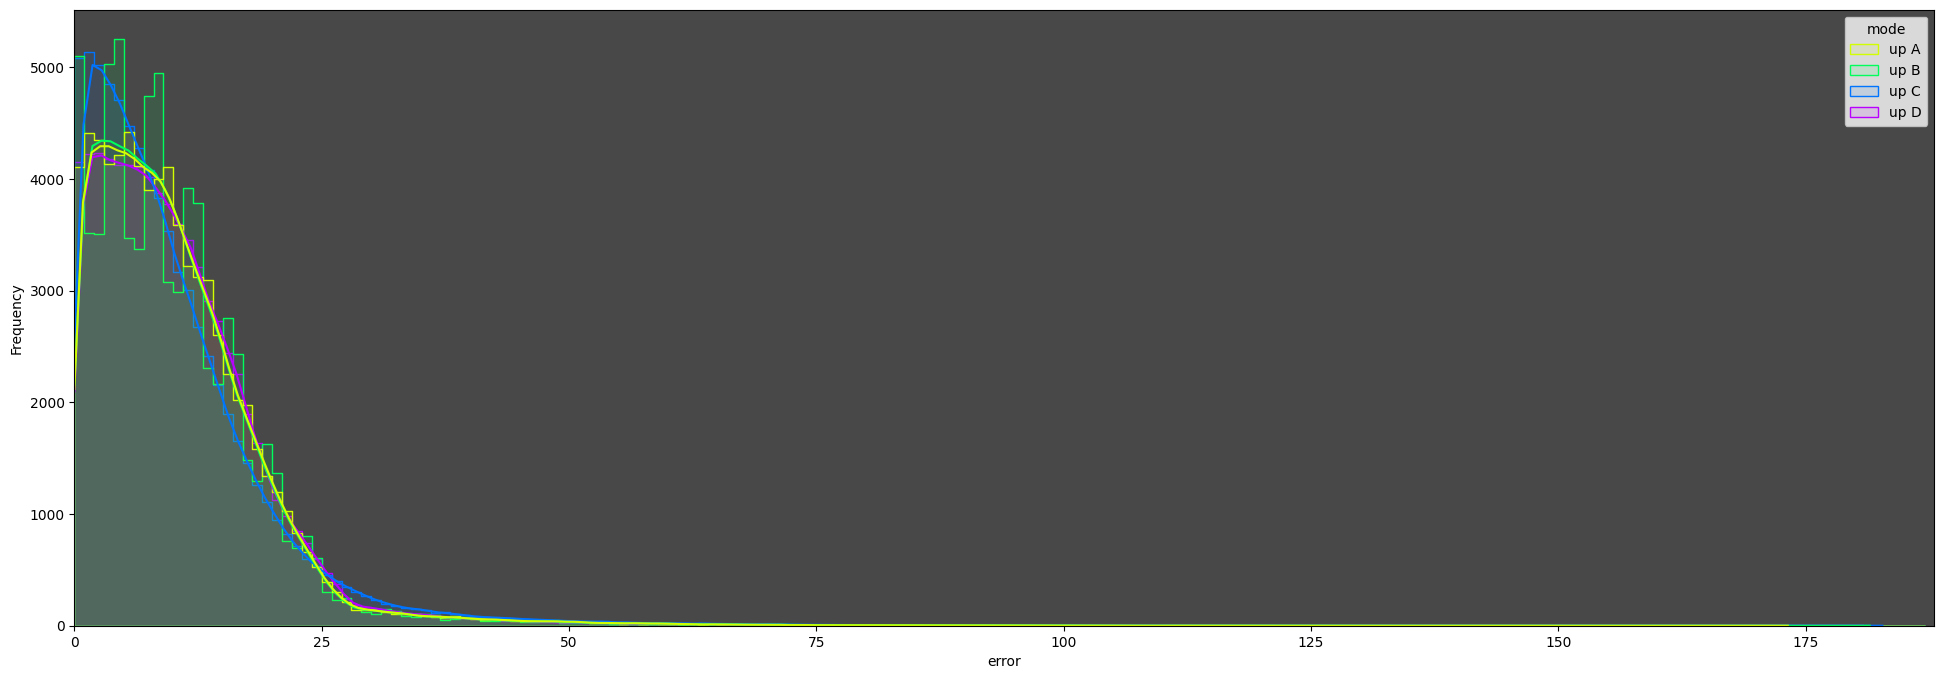

In [20]:
fig, ax = plt.subplots(figsize=(24, 8))
HIST_BINS = [x for x in range(0,188,1)]
p = sns.histplot(x='delta',data=df_comp,palette='hsv',hue="mode",bins=HIST_BINS,stat='frequency',alpha=.1,kde=True,\
             common_norm=True,discrete=False,common_bins=False,fill=True,element='step',multiple='layer',linewidth=1)
p.set_facecolor((.1, .1, .1, .80))
p.set_xlabel("error",fontsize=10)
p.set_ylabel("Frequency",fontsize=10)
p.set_xlim(0,188)
plt.show()

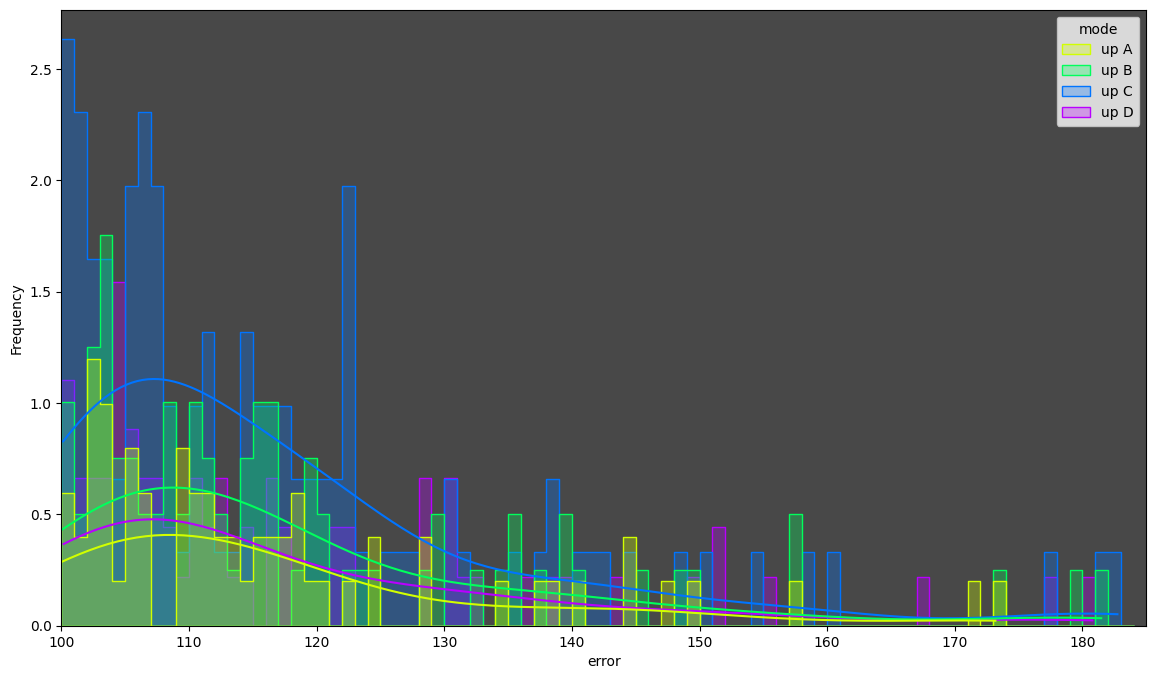

In [21]:
fig, ax = plt.subplots(figsize=(14, 8))
HIST_BINS = [x for x in range(100,185,1)]
p = sns.histplot(x='delta',data=df_comp[df_comp.delta >= 100.0],palette='hsv',hue="mode",bins=HIST_BINS,stat='frequency',alpha=.3,kde=True,\
             common_norm=True,discrete=False,common_bins=False,fill=True,element='step',multiple='layer',linewidth=1)
p.set_facecolor((.1, .1, .1, .80))
p.set_xlabel("error",fontsize=10)
p.set_ylabel("Frequency",fontsize=10)
p.set_xlim(100,185)
plt.show()

In [22]:
df_comp=df_res.copy()[["pA60to15"]].rename(columns={"pA60to15":"pdelta"})
df_comp["mode"] = "pct up A"
df_comp2=df_res.copy()[["pB60to15"]].rename(columns={"pB60to15":"pdelta"})
df_comp2["mode"] = "pct up B"
df_comp3=df_res.copy()[["pC60to15"]].rename(columns={"pC60to15":"pdelta"})
df_comp3["mode"] = "pct up C"
df_comp4=df_res.copy()[["pD60to15"]].rename(columns={"pD60to15":"pdelta"})
df_comp4["mode"] = "pct up D"
df_comp5=df_res.copy()[["pE60to15"]].rename(columns={"pE60to15":"pdelta"})
df_comp5["mode"] = "pct up E"
df_comp=pd.concat([df_comp,df_comp2,df_comp3,df_comp4,df_comp5],ignore_index=True)

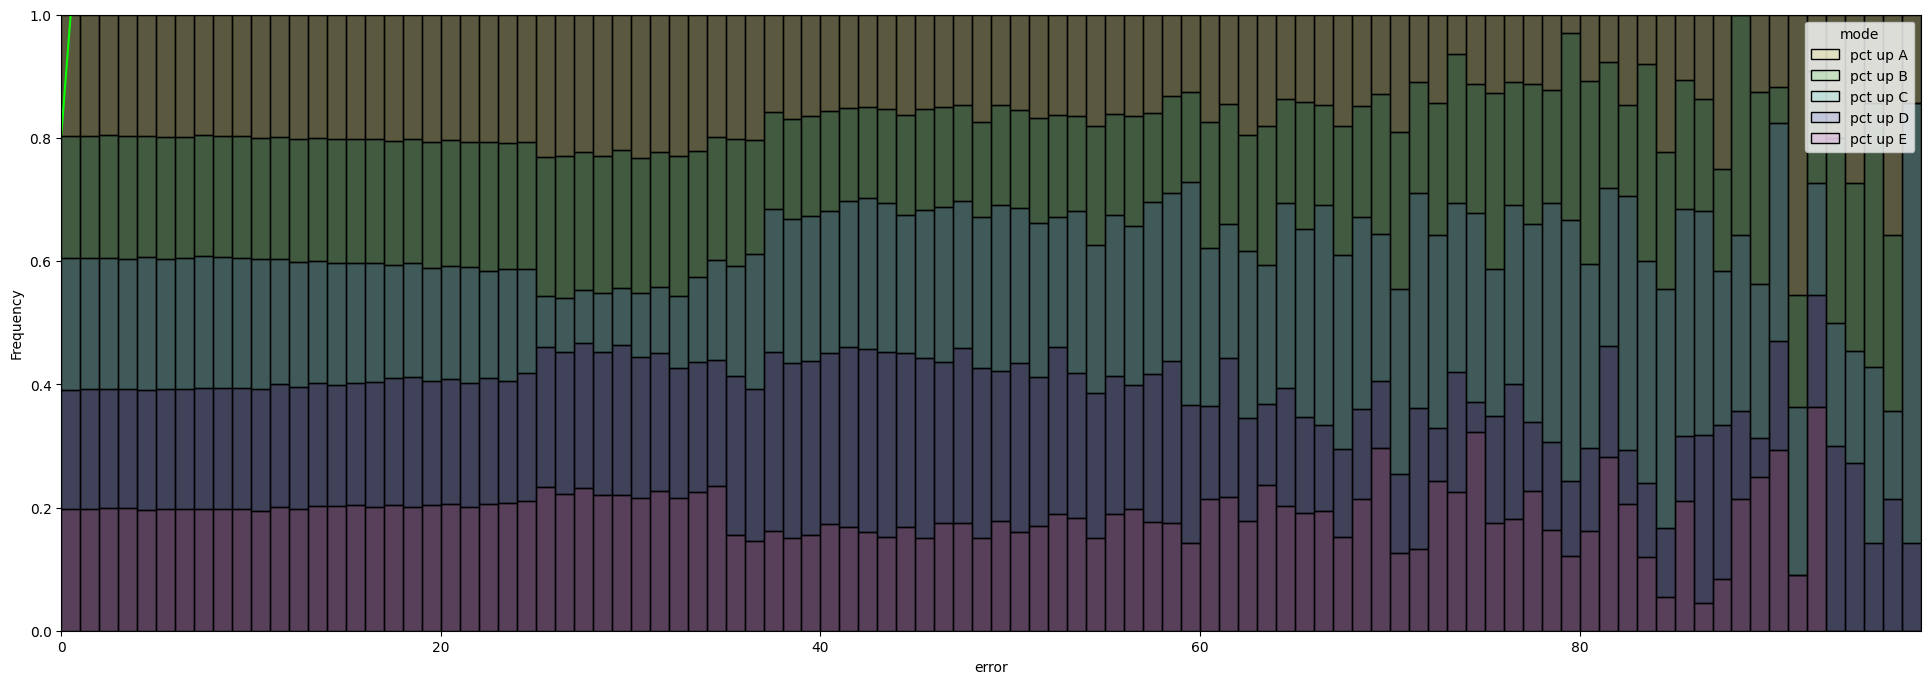

In [23]:
fig, ax = plt.subplots(figsize=(24, 8))
HIST_BINS = [x for x in range(0,99,1)]
p = sns.histplot(x='pdelta',data=df_comp,palette='hsv',hue="mode",bins=HIST_BINS,stat='frequency',alpha=.1,kde=True,\
             common_norm=True,discrete=False,common_bins=False,fill=True,element='bars',multiple='fill',linewidth=1)
p.set_facecolor((.1, .1, .1, .80))
p.set_xlabel("error",fontsize=10)
p.set_ylabel("Frequency",fontsize=10)
p.set_xlim(0,98)
plt.show()

In [24]:
df_comp=df_res.copy()[["dA15to60"]].rename(columns={"dA15to60":"delta"})
df_comp["mode"] = "down A"
df_comp2=df_res.copy()[["dB15to60"]].rename(columns={"dB15to60":"delta"})
df_comp2["mode"] = "down B"
df_comp3=df_res.copy()[["dC15to60"]].rename(columns={"dC15to60":"delta"})
df_comp3["mode"] = "down C"
df_comp4=df_res.copy()[["dD15to60"]].rename(columns={"dD15to60":"delta"})
df_comp4["mode"] = "down D"
df_comp5=df_res.copy()[["dE15to60"]].rename(columns={"dE15to60":"delta"})
df_comp5["mode"] = "down E"
df_comp=pd.concat([df_comp,df_comp2,df_comp3,df_comp4,df_comp5],ignore_index=True)

In [25]:
df_comp

,delta,mode
0,0.00,down A
1,8.63,down A
2,11.17,down A
3,15.81,down A
4,6.53,down A
...,...,...
1478615,6.89,down E
1478616,9.69,down E
1478617,8.68,down E
1478618,7.89,down E


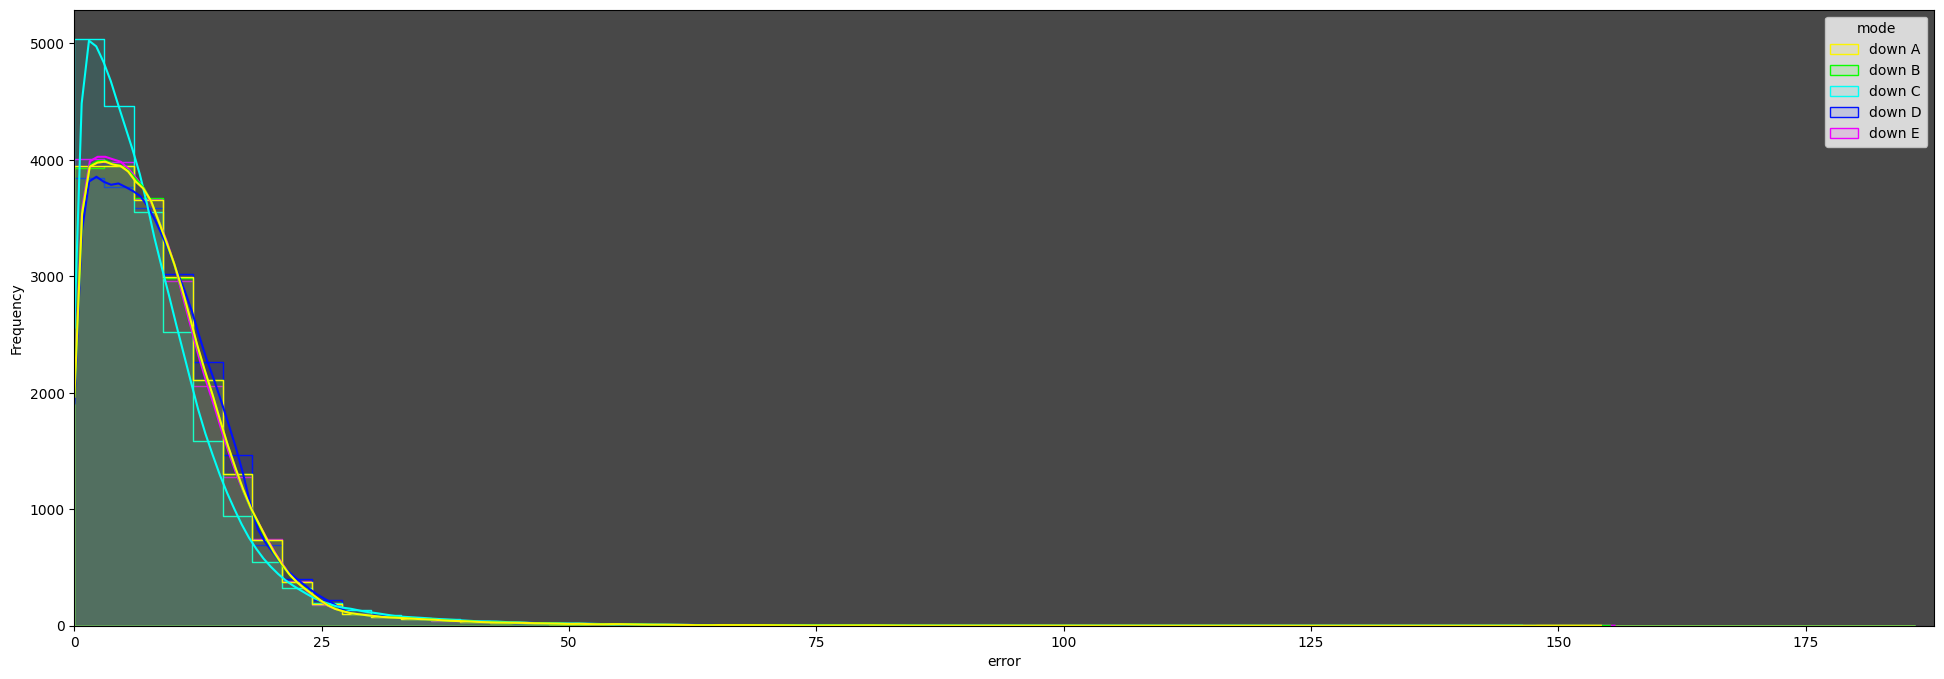

In [26]:
fig, ax = plt.subplots(figsize=(24, 8))
HIST_BINS = [x for x in range(0,188,3)]
p = sns.histplot(x='delta',data=df_comp,palette='hsv',hue="mode",bins=HIST_BINS,stat='frequency',alpha=.1,kde=True,\
             common_norm=True,discrete=False,common_bins=False,fill=True,element='step',multiple='layer',linewidth=1)
p.set_facecolor((.1, .1, .1, .80))
p.set_xlabel("error",fontsize=10)
p.set_ylabel("Frequency",fontsize=10)
p.set_xlim(0,188)
plt.show()

In [27]:
df_real=df_both.copy()[["wpm60"]].rename(columns={"wpm60":"delta"})
df_real["mode"] = "ACTUAL"
df_comp=df_res.copy()[["A15to60"]].rename(columns={"A15to60":"delta"})
df_comp["mode"] = "down A"
df_comp2=df_res.copy()[["B15to60"]].rename(columns={"B15to60":"delta"})
df_comp2["mode"] = "down B"
df_comp3=df_res.copy()[["C15to60"]].rename(columns={"C15to60":"delta"})
df_comp3["mode"] = "down C"
df_comp4=df_res.copy()[["D15to60"]].rename(columns={"D15to60":"delta"})
df_comp4["mode"] = "down D"
df_comp5=df_res.copy()[["E15to60"]].rename(columns={"E15to60":"delta"})
df_comp5["mode"] = "down E"
df_comp=pd.concat([df_real,df_comp,df_comp2,df_comp3,df_comp4,df_comp5],ignore_index=True)

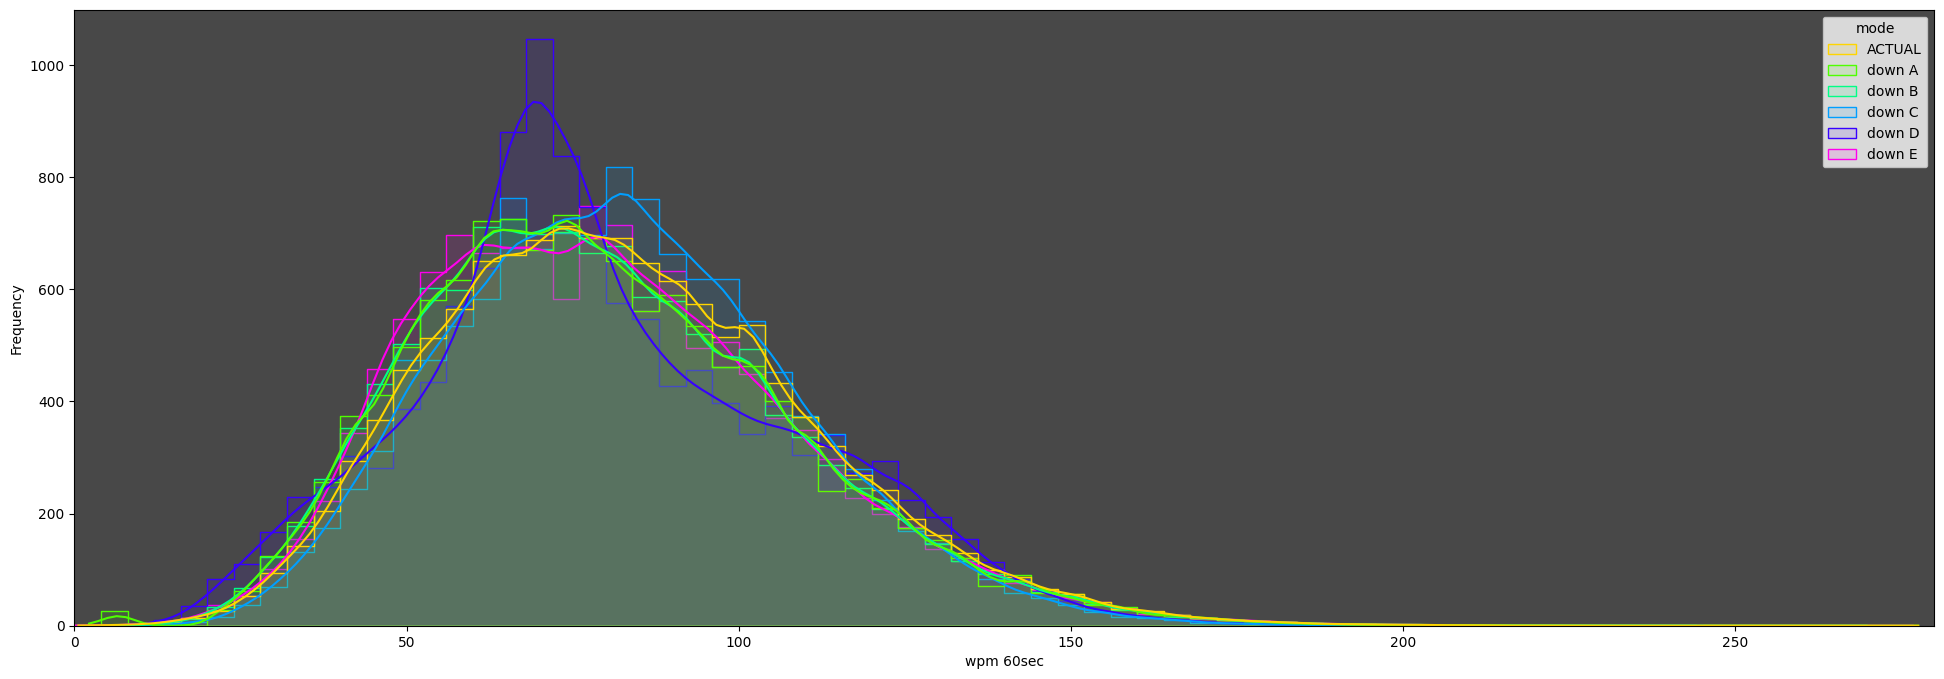

In [28]:
fig, ax = plt.subplots(figsize=(24, 8))
HIST_BINS = [x for x in range(0,280,4)]
p = sns.histplot(x='delta',data=df_comp,palette='hsv',hue="mode",bins=HIST_BINS,stat='frequency',alpha=.1,kde=True,\
             common_norm=True,discrete=False,common_bins=False,fill=True,element='step',multiple='layer',linewidth=1)
p.set_facecolor((.1, .1, .1, .80))
p.set_xlabel("wpm 60sec",fontsize=10)
p.set_ylabel("Frequency",fontsize=10)
p.set_xlim(0,280)
plt.show()

In [39]:
df_real=df_both.copy()[["wpm15"]].rename(columns={"wpm15":"delta"})
df_real["mode"] = "ACTUAL"
df_comp=df_res.copy()[["A60to15"]].rename(columns={"A60to15":"delta"})
df_comp["mode"] = "up A"
df_comp2=df_res.copy()[["B60to15"]].rename(columns={"B60to15":"delta"})
df_comp2["mode"] = "up B"
df_comp3=df_res.copy()[["C60to15"]].rename(columns={"C60to15":"delta"})
df_comp3["mode"] = "up C"
df_comp4=df_res.copy()[["D60to15"]].rename(columns={"D60to15":"delta"})
df_comp4["mode"] = "up D"
df_comp5=df_res.copy()[["E60to15"]].rename(columns={"E60to15":"delta"})
df_comp5["mode"] = "up E"
df_comp=pd.concat([df_real,df_comp,df_comp2,df_comp3,df_comp4,df_comp5],ignore_index=True)

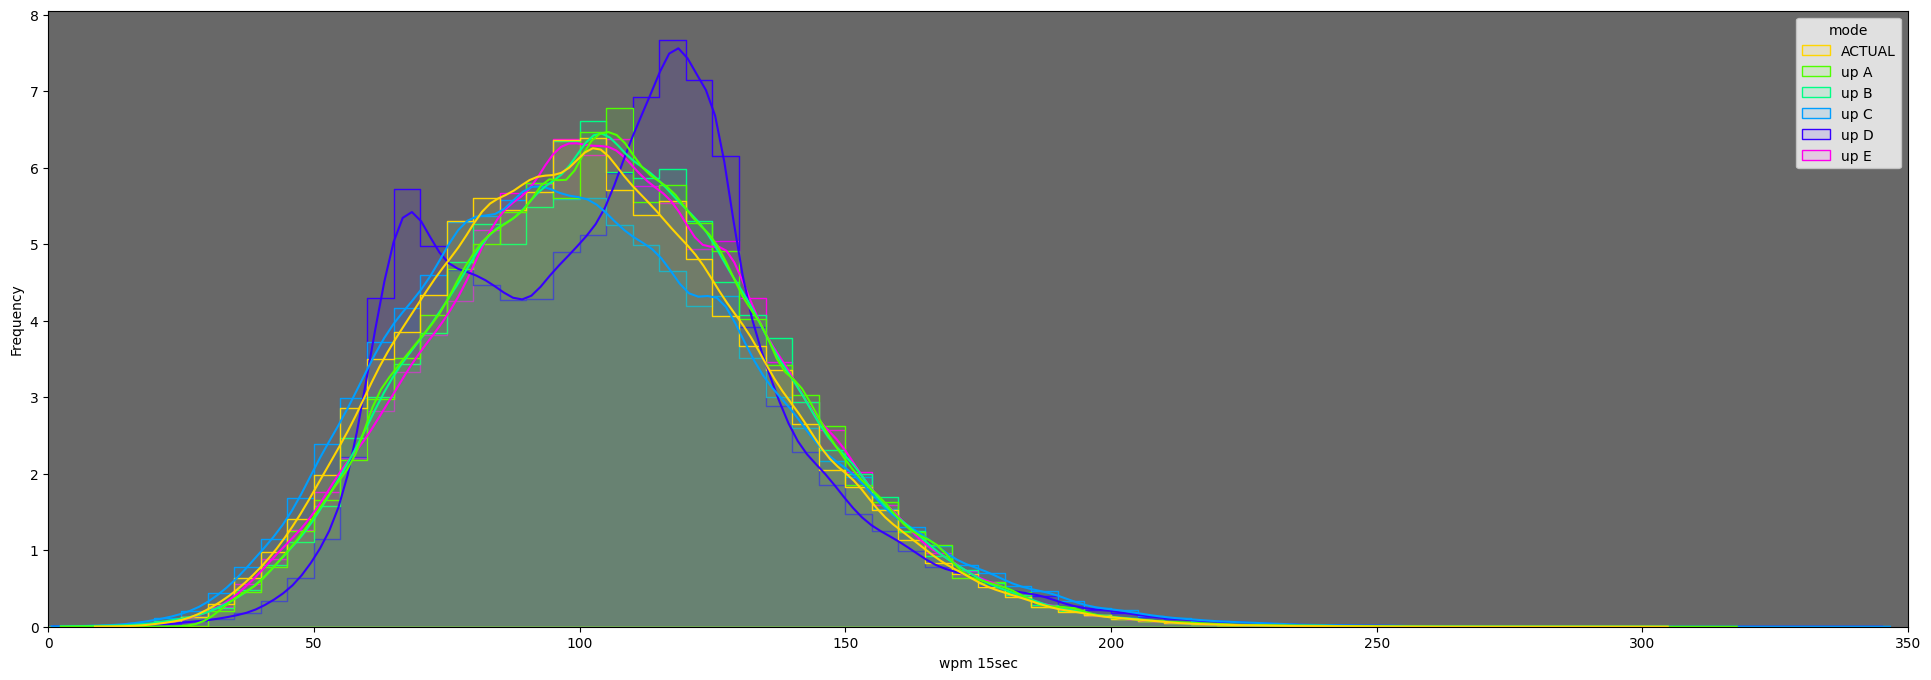

In [56]:
fig, ax = plt.subplots(figsize=(24, 8))
HIST_BINS = [x for x in range(0,350,5)]
p = sns.histplot(x='delta',data=df_comp[df_comp['mode'].apply(lambda x: x in ["ACTUAL","up A","up B","up C","up D","up E"])],palette='hsv',hue="mode",bins=HIST_BINS,stat='percent',alpha=.1,kde=True,\
             common_norm=False,discrete=False,common_bins=False,fill=True,element='step',multiple='layer',linewidth=1)
p.set_facecolor((.01, .01, .01, .60))
p.set_xlabel("wpm 15sec",fontsize=10)
p.set_ylabel("Frequency",fontsize=10)
p.set_xlim(0,350)
plt.show()

In [45]:
df_comp.query("mode == 'up D'")

,delta,mode
1182896,345.09,up D
1182897,332.41,up D
1182898,335.42,up D
1182899,330.20,up D
1182900,309.54,up D
...,...,...
1478615,15.23,up D
1478616,19.95,up D
1478617,14.22,up D
1478618,12.86,up D


In [32]:
df_both.describe()

,wpm15,wpm60
count,295724.000000,295724.000000
mean,102.850216,82.445447
std,32.000832,27.994948
min,8.800000,0.600000
25%,79.950000,62.190000
50%,101.530000,80.180000
75%,123.920000,100.390000
max,304.760000,277.570000
